# Introduction #

First encountering a new dataset can sometimes feel overwhelming. You might be presented with hundreds or thousands of features without even a description to go by. Where do you even begin?

A great first step is to construct a ranking with a **feature utility metric**, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect *any* kind of relationship, while correlation only detects *linear* relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:
- easy to use and interpret,
- computationally efficient,
- theoretically well-founded,
- resistant to overfitting, and,
- able to detect any kind of relationship

# Mutual Information and What it Measures #

Mutual information describes relationships in terms of *uncertainty*. The **mutual information** (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Here's an example from the *Ames Housing* data. The figure shows the relationship between the exterior quality of a house and the price it sold for. Each point represents a house.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/X12ARUK.png" width=400, alt="Four categories of ExterQual: Fair, Typical, Good, Excellent. A scatter plot of SalePrice within each category.">
<figcaption style="textalign: center; font-style: italic"><center>Knowing the exterior quality of a house reduces uncertainty about its sale price.
</center></figcaption>
</figure>

From the figure, we can see that knowing the value of `ExterQual` should make you more certain about the corresponding `SalePrice` -- each category of `ExterQual` tends to concentrate `SalePrice` to within a certain range. The mutual information that `ExterQual` has with `SalePrice` is the average reduction of uncertainty in `SalePrice` taken over the four values of `ExterQual`. Since `Fair` occurs less often than `Typical`, for instance, `Fair` gets less weight in the MI score.

(Technical note: What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.)

# Interpreting Mutual Information Scores #

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

The next figure will give you an idea of how MI values correspond to the kind and degree of association a feature has with the target.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Dt75E1f.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center><strong>Left:</strong> Mutual information increases as the dependence between feature and target becomes tighter. <strong>Right:</strong> Mutual information can capture any kind of association (not just linear, like correlation.)
</center></figcaption>
</figure>

Here are some things to remember when applying mutual information:
- MI can help you to understand the *relative potential* of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI *can't detect interactions* between features. It is a **univariate** metric.
- The *actual* usefulness of a feature *depends on the model you use it with*. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

# Example - 1985 Automobiles #

The [*Automobile*](https://www.kaggle.com/toramky/automobile-dataset) dataset consists of 193 cars from the 1985 model year. The goal for this dataset is to predict a car's `price` (the target) from 23 of the car's features, such as `make`, `body_style`, and `horsepower`. In this example, we'll rank the features with mutual information and investigate the results by data visualization.

This hidden cell imports some libraries and loads the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")

df = pd.read_csv("/content/drive/MyDrive/github_repos/data_analysis/feature_engineering/datasets/autos.csv")
df.head()

<ipython-input-4-5bbfc7f7a91f>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that *must* have a `float` dtype is *not* discrete. Categoricals (`object` or `categorial` dtype) can be treated as discrete by giving them a label encoding. (You can review label encodings in our [Categorical Variables](http://www.kaggle.com/alexisbcook/categorical-variables) lesson.)

In [7]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

print(discrete_features)
X.head()

symboling             True
make                  True
fuel_type             True
aspiration            True
num_of_doors          True
body_style            True
drive_wheels          True
engine_location       True
wheel_base           False
length               False
width                False
height               False
curb_weight           True
engine_type           True
num_of_cylinders      True
engine_size           True
fuel_system           True
bore                 False
stroke               False
compression_ratio     True
horsepower            True
peak_rpm              True
city_mpg              True
highway_mpg           True
dtype: bool


,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
1,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
2,1,0,0,0,2,1,0,0,94.5,171.2,...,6,152,0,2.68,3.47,9,154,5000,19,26
3,2,1,0,0,4,2,1,0,99.8,176.6,...,4,109,0,3.19,3.40,10,102,5500,24,30
4,2,1,0,0,4,2,2,0,99.4,176.6,...,5,136,0,3.19,3.40,8,115,5500,18,22


Scikit-learn has two mutual information metrics in its `feature_selection` module: one for real-valued targets (`mutual_info_regression`) and one for categorical targets (`mutual_info_classif`). Our target, `price`, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [8]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb_weight          1.516501
highway_mpg          0.949989
length               0.617274
bore                 0.500099
stroke               0.392779
num_of_cylinders     0.329184
compression_ratio    0.135022
fuel_type            0.048120
Name: MI Scores, dtype: float64

And now a bar plot to make comparisions easier:

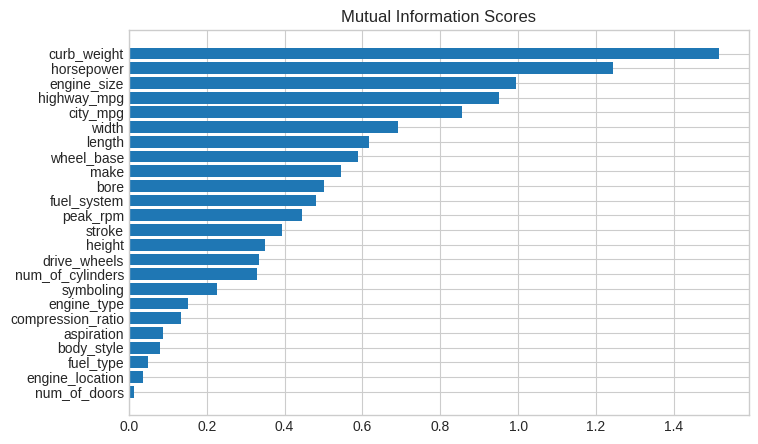

In [9]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Data visualization is a great follow-up to a utility ranking. Let's take a closer look at a couple of these.

As we might expect, the high-scoring `curb_weight` feature exhibits a strong relationship with `price`, the target.


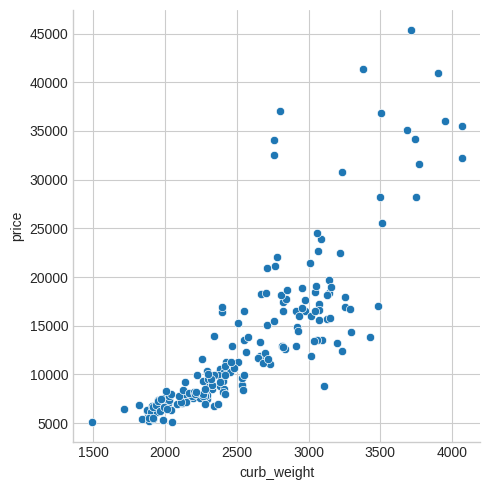

In [10]:
sns.relplot(x="curb_weight", y="price", data=df);

The `fuel_type` feature has a fairly low MI score, but as we can see from the figure, it clearly separates two `price` populations with different trends within the `horsepower` feature. This indicates that `fuel_type` contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

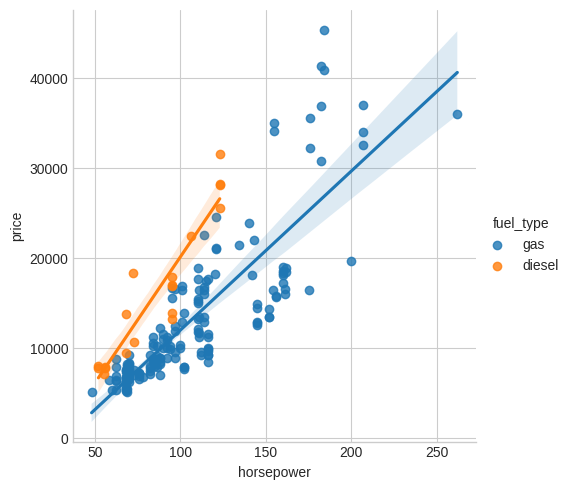

In [11]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

**This notebook is an exercise in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/mutual-information).**

---


# Introduction #

In this exercise you'll identify an initial set of features in the [*Ames*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset to develop using mutual information scores and interaction plots.

Run this cell to set everything up!

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


# Load data
df = pd.read_csv("/content/drive/MyDrive/github_repos/data_analysis/feature_engineering/datasets/ames.csv")


# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

<ipython-input-15-b8633f1bb917>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


-------------------------------------------------------------------------------

To start, let's review the meaning of mutual information by looking at a few features from the *Ames* dataset.

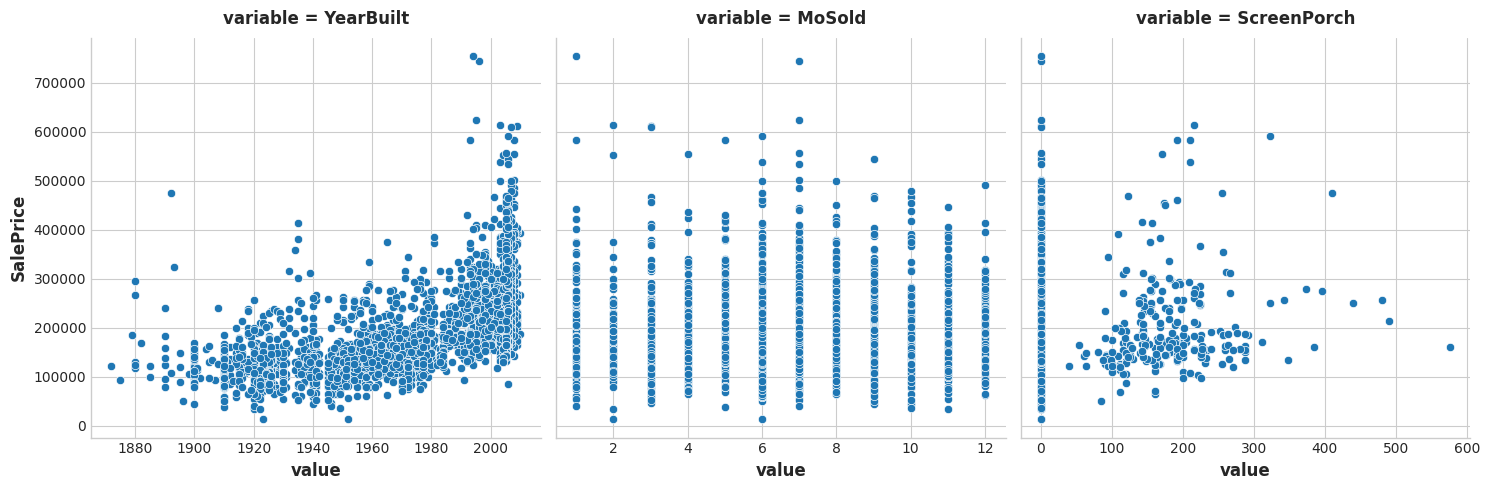

In [ ]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

# 1) Understand Mutual Information

Based on the plots, which feature do you think would have the highest mutual information with `SalePrice`?

In [ ]:
# View the solution (Run this cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Based on the plots, `YearBuilt` should have the highest MI score since knowing the year tends to constrain `SalePrice` to a smaller range of possible values. This is generally not the case for `MoSold`, however. Finally, since `ScreenPorch` is usually just one value, 0, on average it won't tell you much about `SalePrice` (though more than `MoSold`) .

-------------------------------------------------------------------------------

The *Ames* dataset has seventy-eight features -- a lot to work with all at once! Fortunately, you can identify the features with the most potential.

Use the `make_mi_scores` function (introduced in the tutorial) to compute mutual information scores for the *Ames* features:


In [ ]:
X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)

Now examine the scores using the functions in this cell. Look especially at top and bottom ranks.

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64
ExterCond           0.020934
KitchenAbvGr        0.017677
BsmtHalfBath        0.013719
LotConfig           0.013637
ScreenPorch         0.012981
PoolArea            0.012831
MiscVal             0.010997
LowQualFinSF        0.009328
Heating             0.007622
Functional          0.006380
MiscFeature         0.004322
Street              0.003381
Condition2          0.003176
RoofMatl            0.002620
PoolQC              0.001370
Utilities           0.000291
Thre

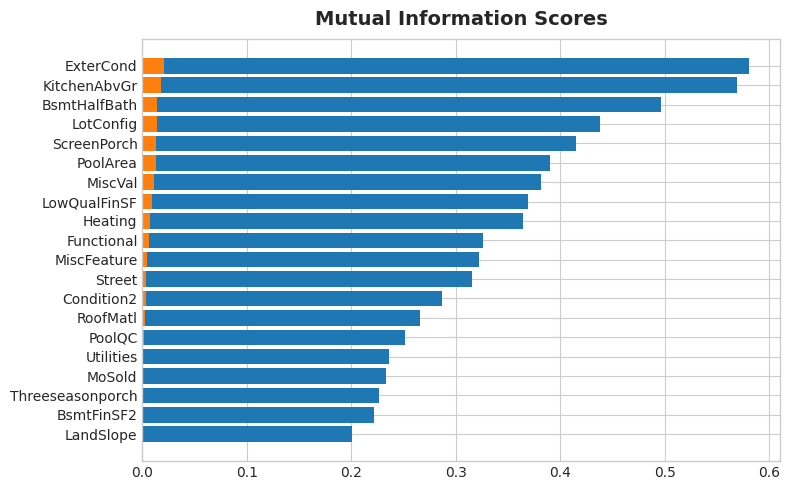

In [ ]:
print(mi_scores.head(20))
print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

# 2) Examine MI Scores

Do the scores seem reasonable? Do the high scoring features represent things you'd think most people would value in a home? Do you notice any themes in what they describe?

In [ ]:
# View the solution (Run this cell to receive credit!)
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Some common themes among most of these features are:
- Location: `Neighborhood`
- Size: all of the `Area` and `SF` features, and counts like `FullBath` and `GarageCars`
- Quality: all of the `Qual` features
- Year: `YearBuilt` and `YearRemodAdd`
- Types: descriptions of features and styles like `Foundation` and `GarageType`

These are all the kinds of features you'll commonly see in real-estate listings (like on Zillow), It's good then that our mutual information metric scored them highly. On the other hand, the lowest ranked features seem to mostly represent things that are rare or exceptional in some way, and so wouldn't be relevant to the average home buyer.


-------------------------------------------------------------------------------

In this step you'll investigate possible interaction effects for the `BldgType` feature. This feature describes the broad structure of the dwelling in five categories:

> Bldg Type (Nominal): Type of dwelling
>
>       1Fam	Single-family Detached
>       2FmCon	Two-family Conversion; originally built as one-family dwelling
>       Duplx	Duplex
>       TwnhsE	Townhouse End Unit
>       TwnhsI	Townhouse Inside Unit

The `BldgType` feature didn't get a very high MI score. A plot confirms that the categories in `BldgType` don't do a good job of distinguishing values in `SalePrice` (the distributions look fairly similar, in other words):

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

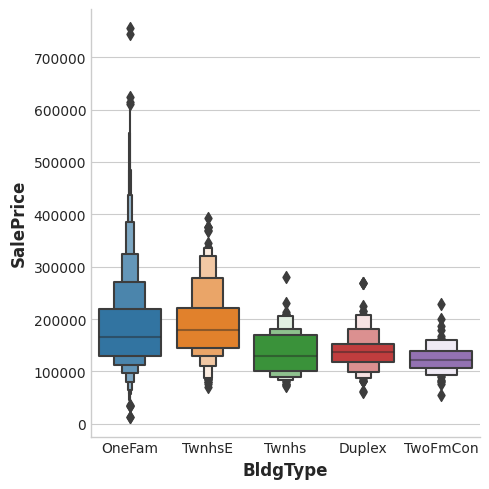

In [ ]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

Still, the type of a dwelling seems like it should be important information. Investigate whether `BldgType` produces a significant interaction with either of the following:

```
GrLivArea  # Above ground living area
MoSold     # Month sold
```

Run the following cell twice, the first time with `feature = "GrLivArea"` and the next time with `feature="MoSold"`:

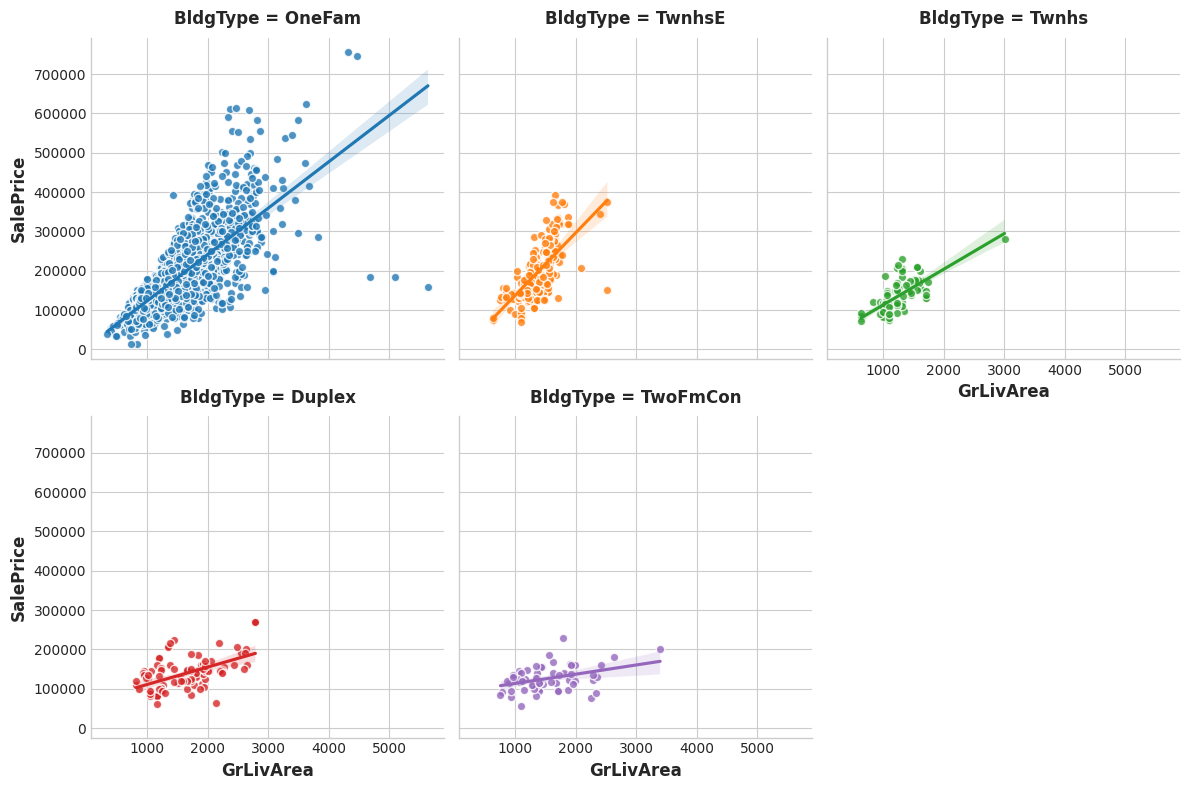

In [ ]:
# YOUR CODE HERE:
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

The trend lines being significantly different from one category to the next indicates an interaction effect.

# 3) Discover Interactions

From the plots, does `BldgType` seem to exhibit an interaction effect with either `GrLivArea` or `MoSold`?

In [ ]:
# View the solution (Run this cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The trends lines within each category of `BldgType` are clearly very different, indicating an interaction between these features. Since knowing `BldgType` tells us more about how `GrLivArea` relates to `SalePrice`, we should consider including `BldgType` in our feature set.

The trend lines for `MoSold`, however, are almost all the same. This feature hasn't become more informative for knowing `BldgType`.

# A First Set of Development Features #

Let's take a moment to make a list of features we might focus on. In the exercise in Lesson 3, you'll start to build up a more informative feature set through combinations of the original features you identified as having high potential.

You found that the ten features with the highest MI scores were:

In [ ]:
mi_scores.head(10)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
Name: MI Scores, dtype: float64

Do you recognize the themes here? Location, size, and quality. You needn't restrict development to only these top features, but you do now have a good place to start. Combining these top features with other related features, especially those you've identified as creating interactions, is a good strategy for coming up with a highly informative set of features to train your model on.

# Keep Going #

[**Start creating features**](https://www.kaggle.com/ryanholbrook/creating-features) and learn what kinds of transformations different models are most likely to benefit from.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*